In [1]:
from casadi import *

In [2]:
# Set up the problem
N = 100 # number of control intervals
opti = Opti() # optimization problem

# Declare the decision variables
X = opti.variable(2, N+1) # State trajectory
pos = X[0,:]
speed = X[1,:]
U = opti.variable(1,N) # control trajectory (throttle) 
T = opti.variable() # final time

In [3]:
# Set up the objective
opti.minimize(T) # race in minimal time

f = lambda x,u: vertcat(x[1],u-x[1]) # dx/dt = f(x,u)

In [4]:
dt = T/N # Control interval
for k in range(N): # Loop over control intervals
    k1 = f(X[:,k], U[:,k])
    k2 = f(X[:,k] + dt/2*k1, U[:,k])
    k3 = f(X[:,k] + dt/2*k2, U[:,k])
    k4 = f(X[:,k] + dt*k3, U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4)
    opti.subject_to(X[:,k+1] == x_next)

In [5]:
# Set the path constraints
limit = lambda pos: 1-sin(2*pi*pos)/2
opti.subject_to(speed <= limit(pos)) # track speed limit
opti.subject_to(opti.bounded(0,U,1)) # control is limited

In [6]:
# Set boundary conditions
opti.subject_to(pos[0]==0) # start at position 0
opti.subject_to(speed[0]==0) # from stand still
opti.subject_to(pos[-1]==1)

# One extra constraint
opti.subject_to(T>=0) # time must be positive

In [7]:
# Provide an initial guess for the solver
opti.set_initial(speed, 1)
opti.set_initial(T, 1)

In [8]:
opti.solver('ipopt') # set numerical backend
sol = opti.solve() # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      903
Number of nonzeros in inequality constraint Jacobian.:      303
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality c

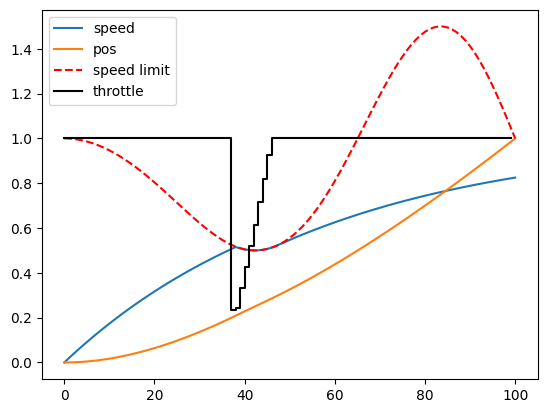

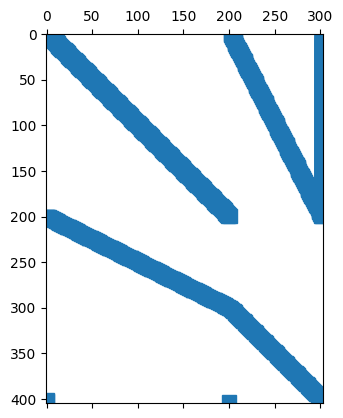

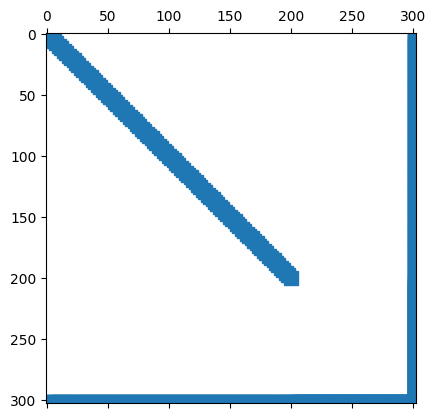

In [10]:
from pylab import plot, step, figure, legend, show, spy

plot(sol.value(speed),label="speed")
plot(sol.value(pos),label="pos")
plot(limit(sol.value(pos)),'r--',label="speed limit")
step(range(N),sol.value(U),'k',label="throttle")
legend(loc="upper left")

figure()
spy(sol.value(jacobian(opti.g,opti.x)))
figure()
spy(sol.value(hessian(opti.f+dot(opti.lam_g,opti.g),opti.x)[0]))

show()